In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import Size, Divider

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)
import gzip
from os.path import isfile
import json

# load path_figures from config_user.json if it exists
path_config = "../config_user.json"
if isfile(path_config):
    with open(path_config, 'r') as f:
        config = json.load(f)
else:
    with open("../config_default.json", 'r') as f:
        config = json.load(f)

path_figures = config["path_figures"]
print(path_figures)
path_data = config["path_data"]
print(path_data)

/Users/johannes/research/figures_perspective_heart_brain/subfigures/
/Users/johannes/research/figures_perspective_heart_brain/data/


In [2]:
savefig_args = {
    'transparent': True,
    'format': 'pdf',
    'dpi': 300,
}
plt.text.usetex : True
# font size
plt.rcParams.update({'font.size': 8})
# # tick size
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

# native unit is inches, convert to mm by introducting a "unit scale" that is used as scalar * mm (e.g. 1*mm = 1/25.4 in inch)
mm = 1/25.4  # mm in inches

## Load data

In [3]:
import pandas as pd
# load action potentials (times, duration, id) for rater plots
filename = path_data + 'FHN_erdos_renyi_m=0.005_raster.txt'
if isfile(filename):
    df_raster_healthy = pd.read_csv(filename, sep=' ')
else:
    raise ValueError(f"{filename} not found")

filename = path_data + 'FHN_erdos_renyi_m=0.005_collective_signal.txt'
if isfile(filename):
    df_collective_healthy = pd.read_csv(filename, sep=' ')
else:
    raise ValueError(f"{filename} not found")

# pathological data
filename = path_data + 'FHN_erdos_renyi_m=0.145_collective_signal.txt'
if isfile(filename):
    df_collective_burst = pd.read_csv(filename, sep=' ')
else:
    raise ValueError(f"{filename} not found")

In [4]:
df_collective_burst.head()

,time,collective,signal
0,0.0,0.105055,NaN
1,1.0,0.293286,NaN
2,2.0,0.457524,NaN
3,3.0,0.584724,NaN
4,4.0,0.716557,NaN


## Alignment 

In [5]:
# select 8s of data (in ms)
# time_range = [1700, 9700]
time_range = np.array([3700, 9700])
height_bar = 0.7

## Raster plot

In [6]:
raster_data = {
    "m=0.005_raster_random": df_raster_healthy,
}

# random selection of 200 neurons
ids_sel = np.random.choice(df_raster_healthy['id'].unique(), 200)

raster_ids = {
    "m=0.005_raster_random": ids_sel,
}

m=0.005_raster_random


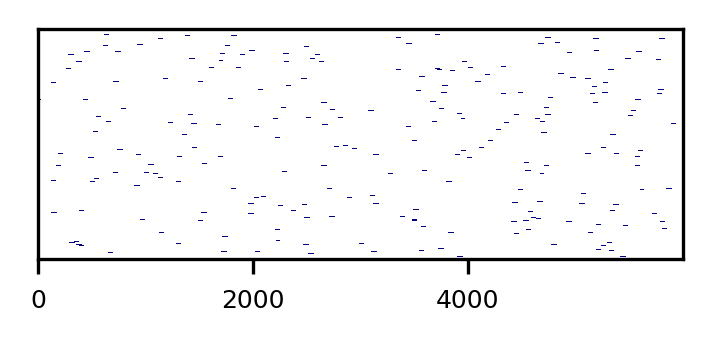

In [7]:
from matplotlib.patches import Rectangle

width = 60 * mm
height = 24 * mm

# iterate over the raster data dictionary
for (label, data) in raster_data.items():
    print(label)
    ids = raster_ids[label]
    # reduce dataframe to ids
    data_plot = data[data['id'].isin(ids)]
    num_nodes = len(ids)

    fig = plt.figure(figsize=(width, height), dpi=300)
    # ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
    # ax = plt.axes([0., 0., 1., 1.])
    ax = plt.axes([0.065, 0.18, 0.91, 0.81], frameon=True, yticks=[])
    # set xticks 
    ax.set_xticks([0,2000,4000])


    # plot all action potentials from dataframe as horizontal lines with y value id and length duration
    for i, row in data_plot.iterrows():
        time = row['time']
        duration = row['duration']
        # index as the location of node in ids
        index = np.where(ids == row['id'])[0][0]
        # plot a rectangle for each action potential in firebrick
        ax.add_patch(Rectangle(xy=(time-time_range[0], num_nodes-index-height_bar/2), width=duration, height=height_bar, facecolor='darkblue'))

    # set limits to time range
    ax.set_xlim(time_range-time_range[0])
    ax.set_ylim(-height_bar/2, num_nodes+height_bar/2)

    # # add scale bars
    # # height of bar should be 1/50 of the figure size (num_nodes+height_bar)
    # ax.add_patch(Rectangle(xy=(scale_time[label], 0), width=scale_time['width'], height=(num_nodes+height_bar)/50, facecolor='black'))
    # add scale bars
    # ax.plot([scale_time[label], scale_time[label]+scale_time['width']], [0, 0], color='black', lw=2)

    # set actual size of figure
    fig.set_size_inches(width, height)

    fig.savefig(path_figures+f"FHN_erdos_renyi_toybrain_{label}.pdf", **savefig_args)

## EEG

In [8]:
collective_data = {
    "m=0.005_collective": df_collective_healthy,
    "m=0.145_collective": df_collective_burst,
}
inset = {
    "m=0.005_collective": (5300, 700, 0.2),
}
signal_range = [-0.9, 2.4]

### large version for Fig. 3

m=0.005_collective
5300


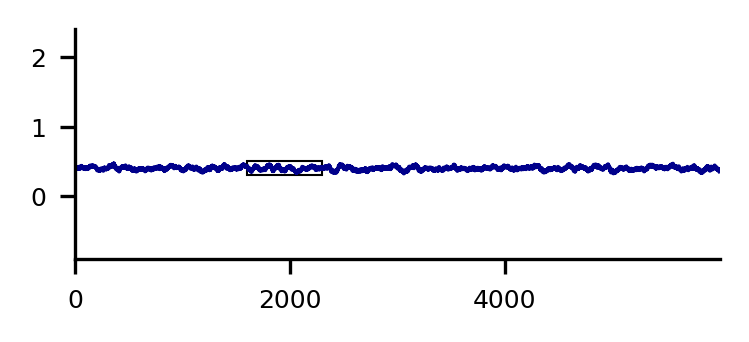

In [9]:
width = 60 * mm
height = 24 * mm

# iterate over the raster data dictionary
label='m=0.005_collective'
df = collective_data[label]
print(label)
fig = plt.figure(figsize=(width, height), dpi=300)
# ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
# ax = plt.axes([0., 0., 1., 1.])
ax = plt.axes([0.065, 0.18, 0.91, 0.81], frameon=True)
# turn off top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set xticks 
ax.set_xticks([0,2000,4000])
# set yticks
ax.set_yticks([0,1,2])


# plot from dataframe time vs signal
df_plot = df[(df['time'] > time_range[0]) & (df['time'] < time_range[1])]
ax.plot(df_plot['time']-time_range[0], df_plot['collective'], color='darkblue', lw=1)

# set limits to time range
ax.set_xlim(time_range - time_range[0])
ax.set_ylim(signal_range)

# # add scale bars
# ax.plot([scale_time[label], scale_time[label]+scale_time['width']], [signal_range[0], signal_range[0]], color='black', lw=2)
# ax.plot([scale_collective['time'], scale_collective['time']], [signal_range[0], signal_range[0]+scale_collective['height']], color='black', lw=1)

# add inset box
if inset[label] is not None:
    time, duration, dy = inset[label]
    mean_y = np.mean(df_plot['collective'])
    print(time)
    # draw a rectangle
    ax.add_patch(Rectangle(xy=(time - time_range[0], mean_y-dy/2), width=duration, height=dy, edgecolor='black', facecolor='none', lw=0.5))
    # ax.plot([time, time], [mean_y-dy/2, mean_y+dy/2], color='black', lw=1)

# set actual size of figure
fig.set_size_inches(width, height)

fig.savefig(path_figures+f"FHN_erdos_renyi_toybrain_{label}.pdf", **savefig_args)

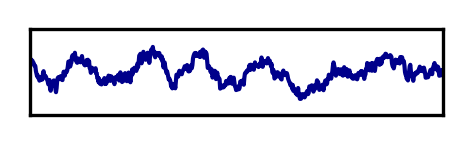

In [10]:
# plot insets (self-consistent scale the inset by factor 5
width_ref = 60 * mm
height_ref = 24 * mm 
factor = 5

label='m=0.005_collective'
data = inset[label]
time, duration, dy = data

width = width_ref * duration / np.diff(time_range)[0] * factor
height = height_ref * dy / np.diff(signal_range)[0] * factor
fig = plt.figure(figsize=(width, height), dpi=300)
ax = plt.axes([0., 0., 1., 1.], frameon=True, xticks=[],yticks=[])
# ax = plt.axes([0., 0., 1., 1.])

# plot from dataframe time vs signal
df = collective_data[label]
df_plot = df[(df['time'] > time) & (df['time'] < time+duration)]
ax.plot(df_plot['time'], df_plot['collective'], color='darkblue', lw=1)

# set limits to time range
ax.set_xlim([time, time+duration])
mean_y = np.mean(df_plot['collective'])
ax.set_ylim([mean_y-dy/2, mean_y+dy/2])

# set actual size of figure
fig.set_size_inches(width, height)

fig.savefig(path_figures+f"FHN_erdos_renyi_toybrain_{label}_inset.pdf", **savefig_args)



### small version for Fig. 4

In [83]:
scale_time = {
    'm=0.005_collective': 5740,
    'm=0.145_collective': 5740,
    'width': 500
}

scale_collective = {
    'time': 5725,
    'height': 10,
}

m=0.005_collective
m=0.145_collective


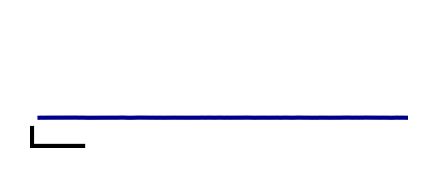

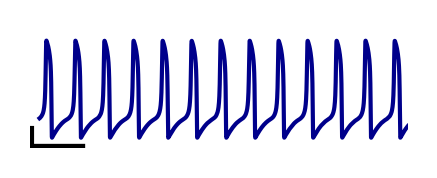

In [85]:
width = 32 * mm
height = 10 * mm

signal_range = [-15, 45.0]
time_range_small = np.array([5700, 9700])

# iterate over the raster data dictionary
for (label, df) in collective_data.items():
    print(label)
    fig = plt.figure(figsize=(width, height), dpi=300)
    # left, bottom, width, height
    ax = plt.axes([0.0, 0.0, 1.0, 1.0], frameon=False, xticks=[],yticks=[])
    # ax = plt.axes([0., 0., 1., 1.])

    # plot from dataframe time vs signal
    shift = 100
    df_plot = df[(df['time'] > time_range_small[0] + shift) & (df['time'] < time_range_small[1])]
    ax.plot(df_plot['time'], df_plot['collective'], color='darkblue', lw=1)
    
    # set limits to time range
    ax.set_xlim(time_range_small)
    ax.set_ylim(signal_range)

    # add scale bars
    ax.plot([scale_time[label], scale_time[label]+scale_time['width']], [signal_range[0], signal_range[0]], color='black', lw=2)
    ax.plot([scale_collective['time'], scale_collective['time']], [signal_range[0], signal_range[0]+scale_collective['height']], color='black', lw=1)

    # set actual size of figure
    fig.set_size_inches(width, height)
    
    fig.savefig(path_figures+f"FHN_erdos_renyi_toybrain_{label}_small.pdf", **savefig_args)

## Snapshots

In [13]:

def plot_graph_on_circle(
    y,
    J,
    ax,
    subset_size=10,
    format_axes=False,
    plot_connections=True,
    arrows=True,
    marker_size=200,
    idle_color="white",
    spiking_color="royalblue",
    weighted_connections_cmap=None,
    weighted_connections_norm=None,
):
    """
    Plot the graph on a circle with nodes colored based on their V value.
    Parameters:
        J (scipy.sparse matrix): adjacency matrix
        y (numpy.ndarray): (N) states of the neurons
        subset_size: number of nodes to plot, if 'all' then subset_size=N
    """
    #J_dense = J.todense()
    J_dense = J
    #else:
   
    N = len(y)

    # Select a subset of nodes to plot
    if type(subset_size) == str and subset_size == "all":
        subset_size = N
    subset_indices = np.random.choice(N, subset_size, replace=False)

    # Create positions for the nodes on a circle
    theta = np.linspace(0, 2 * np.pi, subset_size, endpoint=False)
    positions = np.column_stack((np.cos(theta), np.sin(theta)))

    if format_axes:
        ax.clear()
        ax.set_aspect("equal")
        ax.axis("off")

    # Plot the connections of the subset
    if plot_connections:
        i_indices, j_indices = np.meshgrid(
            subset_indices, subset_indices, indexing="ij"
        )
        mask = J_dense[i_indices, j_indices] != 0
        i_indices, j_indices = i_indices[mask], j_indices[mask]

        for i, j in zip(i_indices, j_indices):
            if type(weighted_connections_cmap) == type(None):
                color = "black"
            else:
                color = weighted_connections_cmap(
                    weighted_connections_norm(J_dense[i, j])
                )
            if arrows:
                ax.arrow(
                    x=positions[i % subset_size, 0],
                    y=positions[i % subset_size, 1],
                    dx=positions[j % subset_size, 0] - positions[i % subset_size, 0],
                    dy=positions[j % subset_size, 1] - positions[i % subset_size, 1],
                    color=color,
                    alpha=1,
                    head_width=0.02,
                    linewidth=0.1,
                    length_includes_head=True,
                    rasterized=True,
                )
            else:
                ax.plot(
                    [positions[i % subset_size, 0], positions[j % subset_size, 0]],
                    [positions[i % subset_size, 1], positions[j % subset_size, 1]],
                    "-",
                    color=color,
                    alpha=0.1,
                    rasterized=True,
                )
    # Add a colorbar with specific ticks
    subset_y = y[subset_indices]
    
    norm = plt.Normalize(vmin=-np.max(np.abs(subset_y)), vmax=np.max(np.abs(subset_y)))
    cmap = plt.get_cmap("seismic")
    
    colors = cmap(norm(subset_y))
    ax.scatter(
        positions[:, 0], positions[:, 1], c=colors, edgecolors=None, s=marker_size, rasterized=True
    )

In [86]:
width = 14 * mm
height = 14 * mm

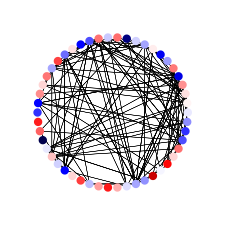

In [87]:
# get state of neurons frmo pickle file
states = pickle.load(gzip.open('./data/FHN_erdos_renyi_toybrain/V_time_evolution_m=0.005.gz', 'rb'))
connections = pickle.load(gzip.open('./data/FHN_erdos_renyi_toybrain/Connectivity_m=0.005.gz', 'rb'))

fig = plt.figure(figsize=(width, height), dpi=300)
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
plot_graph_on_circle(states[:, 0], connections, plt.gca(), subset_size=50, format_axes=True, plot_connections=True, arrows=True, marker_size=1, weighted_connections_cmap=None, weighted_connections_norm=None)
fig.savefig(path_figures+'FHN_erdos-renyi_toybrain_m=0.005_snapshot.pdf', **savefig_args) 

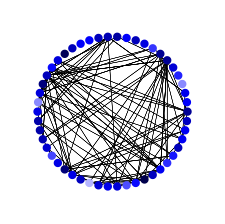

In [88]:

states = pickle.load(gzip.open('./data/FHN_erdos_renyi_toybrain/V_time_evolution_m=0.145.gz', 'rb'))
connections = pickle.load(gzip.open('./data/FHN_erdos_renyi_toybrain/Connectivity_m=0.145.gz', 'rb'))

fig = plt.figure(figsize=(width, height), dpi=300)
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
plot_graph_on_circle(states[:, 1500], connections, plt.gca(), subset_size=50, format_axes=True, plot_connections=True, arrows=True, marker_size=1, weighted_connections_cmap=None, weighted_connections_norm=None)
fig.savefig(path_figures+'FHN_erdos-renyi_toybrain_m=0.145_snapshot.pdf', **savefig_args)